# Squidpy integration

In this notebook, we will describe some usage principles for using SpatialData with squidpy.

Let's first import some useful libraries and read in a spatialdata dataset.

You might have to install squidpy with `!pip install squidpy`.

In [1]:
import scanpy as sc
import spatialdata as sd
import squidpy as sq
import spatialdata_plot  # noqa: F401

/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


We chosed a Xenium dataset formatted in the spatialdata format. 
You can download the data from here: [Xenium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep1_io.zip). Please rename the file to `xenium.zarr` and place it in the same folder as this notebook (or use symlinks to make the data accessible).

In [ ]:
zarrpath = "/Volumes/Share1TB/datasets/lv_0046706_053.zarr"
sdata = sd.read_zarr(zarrpath)
# sdata = sd.read_zarr('/Volumes/Share1TB/datasets/lv_0046706_007.zarr')
# sdata = sd.read_zarr('../datasets/mouse_liver.zarr')
sdata

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/chrism/git/spatialdata-notebooks/.venv/

ArrowInvalid: An error occurred while calling the read_parquet method registered to the pandas backend.
Original Message: Error creating dataset. Could not read schema from '/Volumes/Share1TB/datasets/lv_0046706_007.zarr/points/transcripts/points.parquet/._part.0.parquet'. Is this a 'parquet' file?: Could not open Parquet input source '/Volumes/Share1TB/datasets/lv_0046706_007.zarr/points/transcripts/points.parquet/._part.0.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

SpatialData has a more complex structure than the (legacy) spatial `AnnData` format introduced by `squidpy`. Nevertheless, because it fundamentally uses `AnnData` as table for annotating regions, with some minor adjustments we can readily use any tool from the scverse ecosystem (`squidpy` included) to perform downstream analysis.

More precisely, the `scverse` ecosystem will gradually transition to use `SpatialData` internally; until that moment the function `to_legacy_anndata()` from `spatialdata_io.experimental` can be used to enrich the `AnnData` in `sdata.tables`  objects to be compatible with the legacy `AnnData` format.

Generally (i.e. when a single coordinate system is used), the only adjustment required is to populate `.obsm['spatial']` with the centroids of the geometries being considered, and this is performed automatically by the `spatialdata-io` library. For more complex cases, the converter functions `to_legacy_anndata()` and `from_legacy_anndata()` can be used (see example at the end of the notebook).

## Xenium example

As an example of integration with `Squidpy`, let's compute a nearest neighbor graph of the spatial coordiantes of the xenium dataset.

In [3]:
sq.gr.spatial_neighbors(sdata["table"])

After that, we can cluster the cells based on gene expression profiles and compute clustering.

In [9]:
%%time
sc.pp.pca(sdata["table"])
sc.pp.neighbors(sdata["table"])
sc.tl.leiden(sdata["table"])

CPU times: user 2min 43s, sys: 658 ms, total: 2min 44s
Wall time: 2min 38s


And run the neighbor enrichment analysis in squidpy.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 180.45/s]
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/squidpy/gr/_nhood.py:202: RuntimeWarning: divide by zero encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step


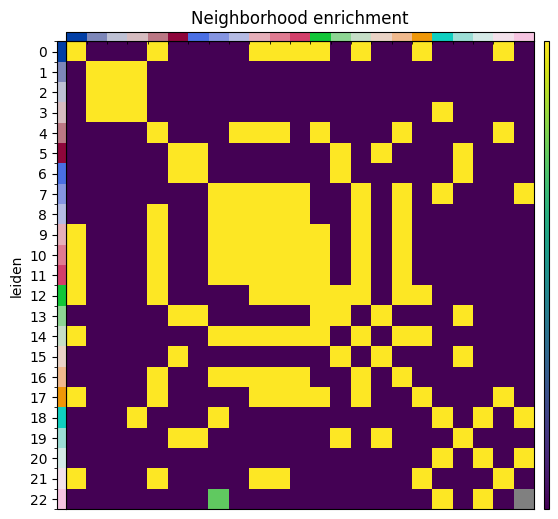

In [7]:
sq.gr.nhood_enrichment(sdata["table"], cluster_key="leiden")
sq.pl.nhood_enrichment(sdata["table"], cluster_key="leiden", figsize=(5, 5))

We can finally visualize the results in spatial coordinates both with squidpy as well as with the novel plotting function in spatialdata.


CPU times: user 82.8 ms, sys: 0 ns, total: 82.8 ms
Wall time: 82.4 ms


/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


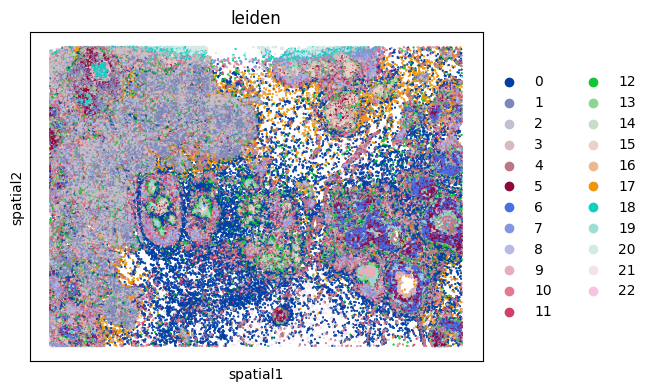

In [10]:
%%time
sq.pl.spatial_scatter(sdata["table"], shape=None, color="leiden")

/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   


/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:775: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


CPU times: user 12.9 s, sys: 1.28 s, total: 14.2 s
Wall time: 10.6 s


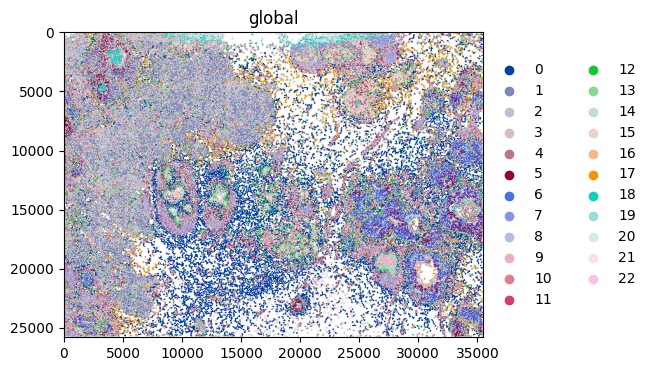

In [11]:
%%time
# currently we need either to use `method='matplotlib`` (which is significantly slower than `method='datashader'`) or we need the one line workaround below because of this bug:
# https://github.com/scverse/spatialdata-plot/issues/291.
sdata["cell_circles"] = sd.transform(sdata["cell_circles"], to_coordinate_system="global")  # workaround
sdata.pl.render_shapes("cell_circles", color="leiden", method="datashader").pl.show(coordinate_systems="global")

## Using the converters from/to the legacy spatial `AnnData` format

We will now show how to convert from/to the legacy spatialdata `AnnData` format. The convertes deal with the complexity of having multiple libraries in the legacy format, and with the generality of coordinate systems in `SpatialData`. For more information please refer to the API documentation of `spatialdata-io`.

In [12]:
from typing import Literal

import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
from spatialdata.datasets import blobs_annotating_element
from spatialdata.transformations import Affine, set_transformation
from spatialdata_io.experimental import from_legacy_anndata, to_legacy_anndata

BlobsTypes = Literal["blobs_labels", "blobs_circles", "blobs_polygons", "blobs_multipolygons"]

/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


### Example of conversion from the legacy AnnData to SpatialData

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89.9M/89.9M [00:19<00:00, 4.90MB/s]


INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `locations` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.053691275..1.1006712].
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `locations` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists

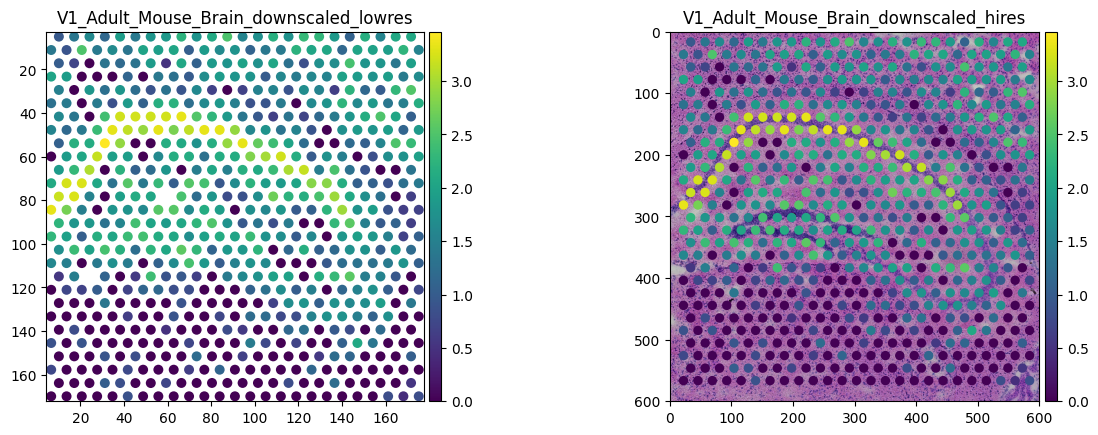

In [13]:
# some datasets you can play around with
# adata = sq.datasets.visium_fluo_adata()
# adata = sq.datasets.merfish()
adata = sq.datasets.visium_hne_adata_crop()

sdata = from_legacy_anndata(adata)

my_gene = "Itpka"
# broken (multiple table not yet supported in spatialdata-plot), this is being fix in https://github.com/scverse/spatialdata-plot/pull/220
sdata.pl.render_images("V1_Adult_Mouse_Brain_hires_image").pl.render_shapes(color=my_gene).pl.show()
plt.show()

### Example of conversion from SpatialData to the legacy AnnData, showing also that affine transformations are handled

/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/models/models.py:1144: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/models/models.py:1144: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/tmp/ipykernel_394777/2475705291.py:13: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


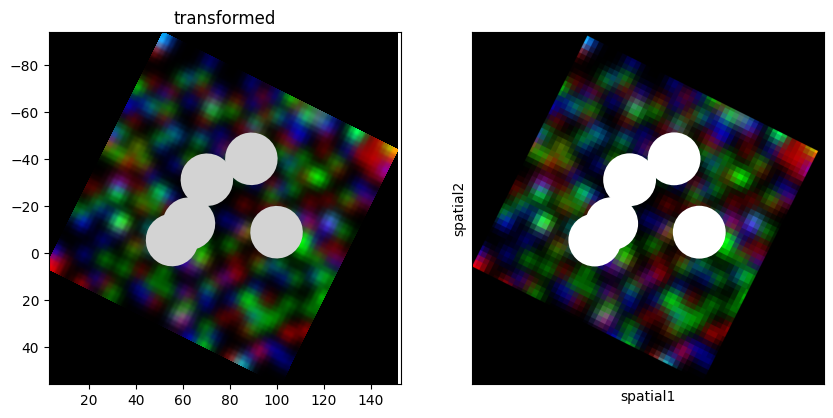

In [14]:
element = "blobs_circles"
sdata = blobs_annotating_element(element)
image = "blobs_multiscale_image"

affine = Affine([[1, 2, 3], [-2, 1, 6], [0, 0, 1]], input_axes=("x", "y"), output_axes=("x", "y"))
set_transformation(sdata[element], affine, "transformed")
set_transformation(sdata[image], affine, "transformed")

adata = to_legacy_anndata(sdata, include_images=True, coordinate_system="transformed")

axes = plt.subplots(1, 2, figsize=(10, 5))[1]
sdata.pl.render_images(image).pl.render_shapes(element).pl.show(coordinate_systems=["transformed"], ax=axes[0])
sc.pl.spatial(
    adata,
    spot_size=300,
    library_id=image,
    img_key="hires",
    na_color="white",
    show=True,
    crop_coord=(0, 2000, 0, 2000),
    ax=axes[1],
)